# Lab 2: Global Optimization with Gaussian Processes

## Based on Gaussian Process Summer School 2022

The goal of this lab session is to illustrate the concepts seen during the tutorial in Gaussian processes for Global optimization. We will focus on two aspects of Bayesian Optimization (BO): (1) the choice of the model (2) the choice of the acquisition function.

## 1. Getting started

In addition to GPflow, this lab uses trieste (https://github.com/secondmind-labs/trieste), a module to solve global optimization problems. Please be sure that it is correctly installed before starting by following the Getting Started page.

Now, just as in the previous lab, specify to include plots in the notebook and to import relevant libraries.

In [1]:
# Silence some annyoing warnings:
import os
import warnings

warnings.simplefilter("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Support for maths
import numpy as np
import tensorflow as tf

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

# GPflow: Gaussian processes library
import gpflow
import trieste

### Remembering the basics

Before starting with the lab, remember that (BO) is an heuristic for global optimization of black-box functions. Let $f: {\mathcal X} \to R$ be a 'well behaved' continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. Our goal is to solve the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\sigma^2)$, are  available. The goal is to find $x_M$ by minimizing the number of evaluations of $f$. To do this, we need to determine two crucial bits:

1. A **Gaussian process** that will capture the our beliefs on $f$. 

2. An **acquisition function** that based on the model will be useful to determine where to collect new evaluations of f. 

Remember that every time a new data point is collected the model is updated and the acquisition function optimized again. 

### Running example

We start with a one-dimensional example. Consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4),$$

defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. We assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.25. To create the true function, the perturbed version and the boundaries of the problem you need to run the following cell. 

In [2]:
def forrester_true(x):
    return (6.*x - 2)**2 * tf.sin(12.*x-4)

def forrester_sim(x):
    y = forrester_true(x)
    noise = tf.random.normal(y.shape, 0.0, 0.25, dtype=y.dtype)
    return y + noise

search_space = trieste.space.Box([0.0], [1.])

f_observer = trieste.objectives.utils.mk_observer(forrester_sim)

To plot the true $f$, simply write:

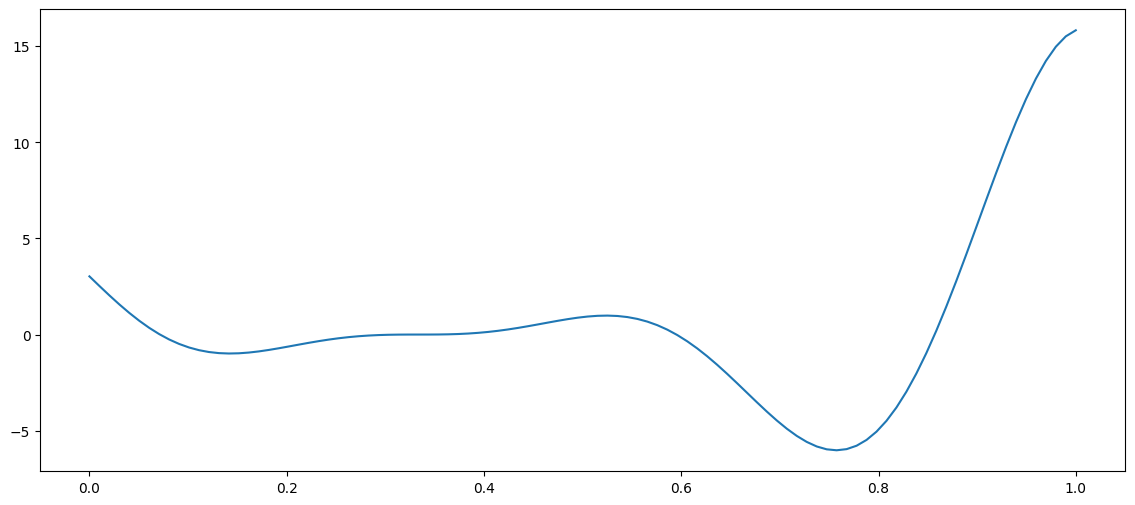

In [3]:
plt.figure(figsize=(14, 6))
Xplot = np.linspace(search_space.lower, search_space.upper, 100)
Yplot = forrester_true(Xplot)
plt.plot(Xplot, Yplot)

f_observer wraps the function we are going to optimise, and makes it return a `Dataset` instead of just Y values. For example:

In [4]:
n = 8
x = np.random.rand(n).reshape(n,1)
x

array([[0.0851305 ],
       [0.0406089 ],
       [0.95095076],
       [0.39990884],
       [0.41189301],
       [0.42688791],
       [0.90495197],
       [0.96027482]])

In [5]:
f_observer(x)

Dataset(query_points=array([[0.0851305 ],
       [0.0406089 ],
       [0.95095076],
       [0.39990884],
       [0.41189301],
       [0.42688791],
       [0.90495197],
       [0.96027482]]), observations=<tf.Tensor: shape=(8, 1), dtype=float64, numpy=
array([[-4.18687345e-01],
       [ 5.61855319e-01],
       [ 1.24355865e+01],
       [-1.43090449e-01],
       [-2.02458658e-01],
       [ 4.25401687e-03],
       [ 6.42613419e+00],
       [ 1.34647965e+01]])>)

Next we need to sample some initial data for our optimization:

In [6]:
initial_query_points = search_space.sample_sobol(3)
initial_data = f_observer(initial_query_points)

To use BO to solve this problem, we need to create a BayesianOptimizer object in which we need to specify the following elements: 
* The function to optimize.
* The box constrains of the problem.
* The model.
* The acquisition function (and its parameters).

Trieste comes with utilities for initialising a reasonable GPflow model:

In [7]:
gpflow_m = trieste.models.gpflow.build_gpr(initial_data, search_space)
m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)

And now we have all the elements to start optimizing $f$. We create the optimization problem instance. Note that you don't need to specify the evaluation budget. This is because at this stage we are not running the optimization, we are just initializing the different elements of the BO algorithm. 

In [8]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(
    f_observer,
    search_space,
)
acquisition_rule = trieste.acquisition.rule.EfficientGlobalOptimization(
    trieste.acquisition.function.ExpectedImprovement()
)

In [9]:
# Run the optimization (may take a few senconds)
max_iter = 15                       # evaluation budget
result = bo.optimize(               # run optimization 
    max_iter,
    initial_data,
    m,
    acquisition_rule,
)

Optimization completed without errors


And that's it! You should have receive a message describing if the optimization worked. In one dimensional examples, you can visualize the model and the acquisition function (normalized between 0 and 1) as follows.

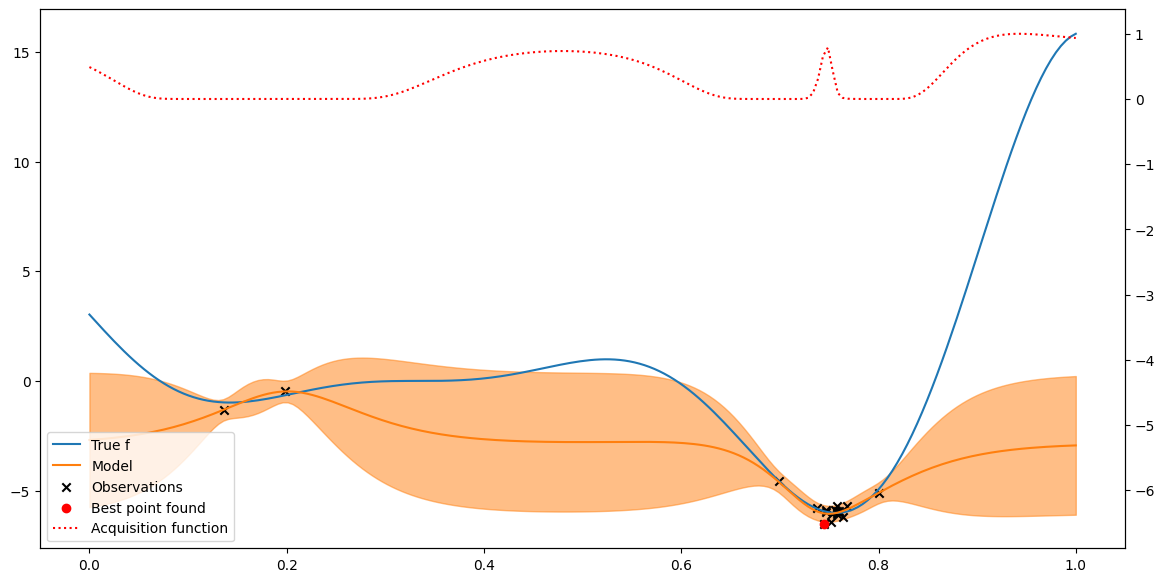

In [10]:
def plot_bo(bo, acq, result, f_true):
    plt.figure(figsize=(14, 7))

    search_space = bo._search_space
    Xplot = np.linspace(search_space.lower, search_space.upper, 200)
    
    legend = []
    
    if f_true is not None:
        Ytrue = f_true(Xplot)
        true_line, = plt.plot(Xplot, Ytrue, label="True f")
        legend.append(true_line)
    
    Ymean, Yvar = result.try_get_final_model().model.predict_y(Xplot)
    model_line, = plt.plot(Xplot, Ymean, label="Model")
    legend.append(model_line)
    
    # Plot 95% confidence interval 
    plt.fill_between(Xplot[:,0],
                     Ymean[:,0] - 1.96*np.sqrt(Yvar[:,0]),
                     Ymean[:,0] + 1.96*np.sqrt(Yvar[:,0]),
                     color=model_line.get_color(),
                     alpha=0.5)
    
    data = result.try_get_final_dataset()
    data_line = plt.scatter(
        data.query_points,
        data.observations,
        marker="x",
        label="Observations",
        color="black",
    )
    legend.append(data_line)
    
    ax2 = plt.gca().twinx()
    
    Xbest, Ybest, idxbest = result.try_get_optimal_point()
    best_point = ax2.scatter(Xbest, Ybest, color="red", label="Best point found")
    legend.append(best_point)
    
    Yacq = acq._acquisition_function(Xplot[:, None, :])
    Yacq_min = tf.reduce_min(Yacq)
    Yacq_max = tf.reduce_max(Yacq)
    Yacq = (Yacq - Yacq_min) / (Yacq_max - Yacq_min)
    acq_line, = ax2.plot(
        Xplot,
        Yacq,
        linestyle=":",
        color="red",
        label="Acquisition function")
    legend.append(acq_line)
    
    plt.legend(
        legend, [l.get_label() for l in legend],
    )

plot_bo(bo, acquisition_rule, result, forrester_true)

You can only make the previous plot if the dimension of the problem is 1 or 2. However, you can always how the optimization evolved by running:

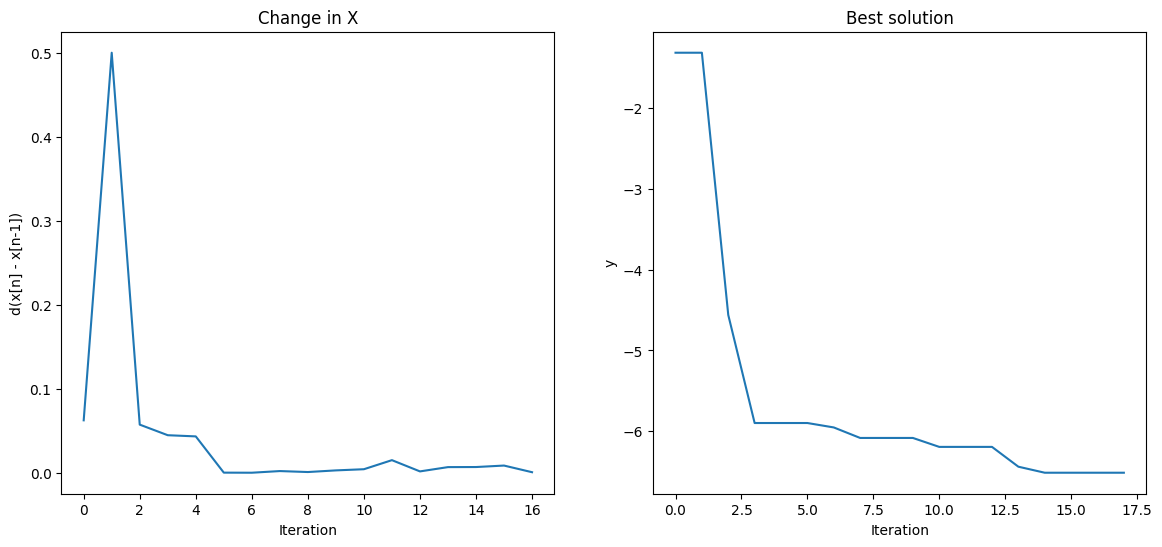

In [11]:
def plot_convergence(result):
    plt.figure(figsize=(14, 6))
    
    data = result.try_get_final_dataset()
    
    plt.subplot(121)
    
    dx = data.query_points[1:] - data.query_points[:-1]
    dist = tf.sqrt(tf.reduce_sum(dx**2, axis=-1))

    plt.plot(range(len(dist)), dist)
    plt.title("Change in X")
    plt.ylabel("d(x[n] - x[n-1])")
    plt.xlabel("Iteration")
    
    plt.subplot(122)
    
    best_y = tf.scan(tf.minimum, data.observations)
    plt.plot(range(len(best_y)), best_y)
    plt.title("Best solution")
    plt.ylabel("y")
    plt.xlabel("Iteration")
    
    

plot_convergence(result)

The first plot shows the distance between the last two collected observations at each iteration. This plot is useful to evaluate the convergence of the method. The second plot shows the best found value at each iteration. It is useful to compare different methods. The fastest the curve decreases the better the method. 

### Exercise 1

Use Bayesian optimization to find the minimum of the function $f(x)= x^2 + 10 \sin(x)$ in the interval [-10, 10]. 

(a) Define a function that implements the above equation in TensorFlow, and create a Trieste observer for it. Test that it works.

In [12]:
def g(x):
    return x**2 + 10*tf.sin(x)

g_observer = trieste.objectives.utils.mk_observer(g)

x = tf.constant(np.random.rand(n).reshape(n,1))
g(x)

<tf.Tensor: shape=(8, 1), dtype=float64, numpy=
array([[3.74820201],
       [3.99545623],
       [2.55964156],
       [7.55145801],
       [0.78695728],
       [5.42502467],
       [8.15894844],
       [7.90796769]])>

(b) Define the search space / bounds of the problem, and use it to sample 3 initial data points.

In [13]:
search_space = trieste.space.Box([-10.], [10.])

initial_query_points = search_space.sample_sobol(3)
initial_data = g_observer(initial_query_points)
initial_data

Dataset(query_points=<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[ 9.51812744],
       [ 4.51812744],
       [-5.48187256]])>, observations=<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[89.66261036],
       [10.60157067],
       [37.23362748]])>)

(c) Create a Trieste model, based on a GPflow GPR. For numerical stability fix the model noise variance to 1e-4.

In [14]:
gpflow_m = trieste.models.gpflow.build_gpr(initial_data, search_space)
gpflow_m.likelihood.variance.assign(1e-4)
gpflow.set_trainable(gpflow_m.likelihood.variance, False)
m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)
m

GaussianProcessRegression(<gpflow.models.gpr.GPR object at 0x787c2d467710>, Optimizer(optimizer=<gpflow.optimizers.scipy.Scipy object at 0x787c2d558c50>, minimize_args={}, compile=True),10, 1000,True)

(d) Create a Trieste optimizer and acquisition rule, and run the optimization for 10 iterations.

In [15]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(
    g_observer,
    search_space,
)
acquisition_rule = trieste.acquisition.rule.EfficientGlobalOptimization(
    trieste.acquisition.function.ExpectedImprovement()
)
result = bo.optimize(
    10,
    initial_data,
    m,
    acquisition_rule,
)

Optimization completed without errors


(e) Plot your results. Has the method converged? 

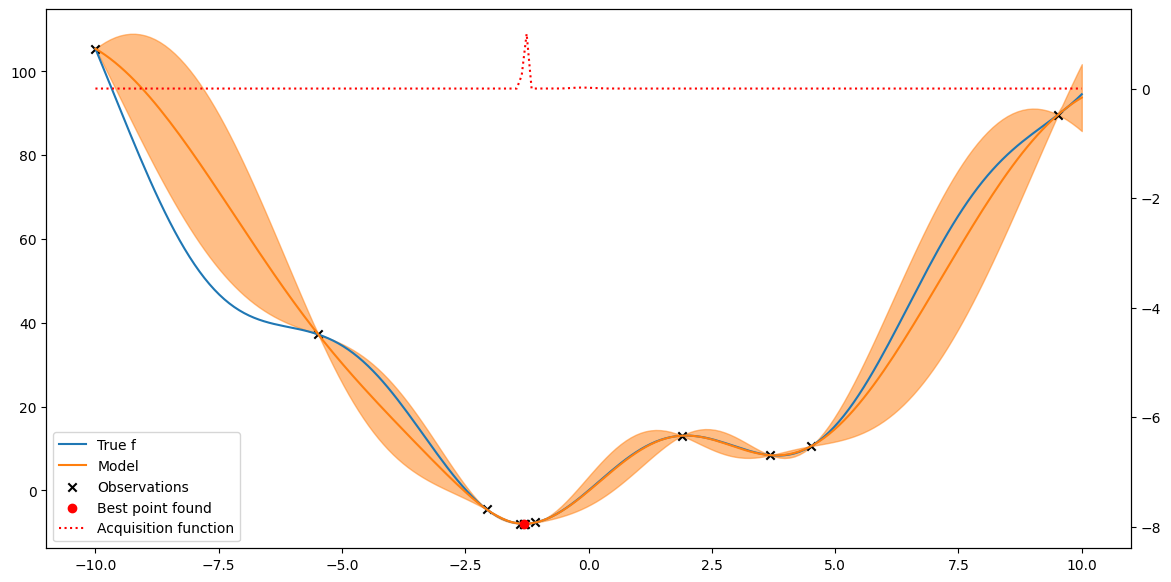

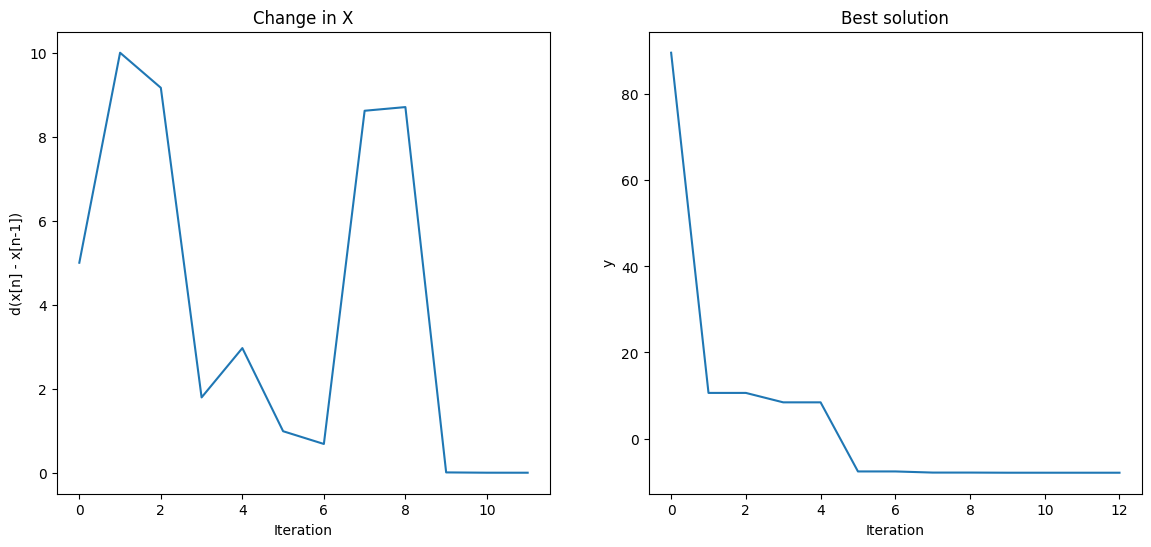

In [16]:
plot_bo(bo, acquisition_rule, result, g)
plot_convergence(result)

## 2. Acquisition functions

In this section we are going to have a look to different acquisition functions. Trieste comes with a battery of acquisition functions, but here we are only going to look at expected improvement (EI), augmented expected improvement (AEI) and lower confidence bound (LCB).

To access these acquisitions 'externally' we create a GP model using the objective function in Section 1 evaluated in 10 locations.

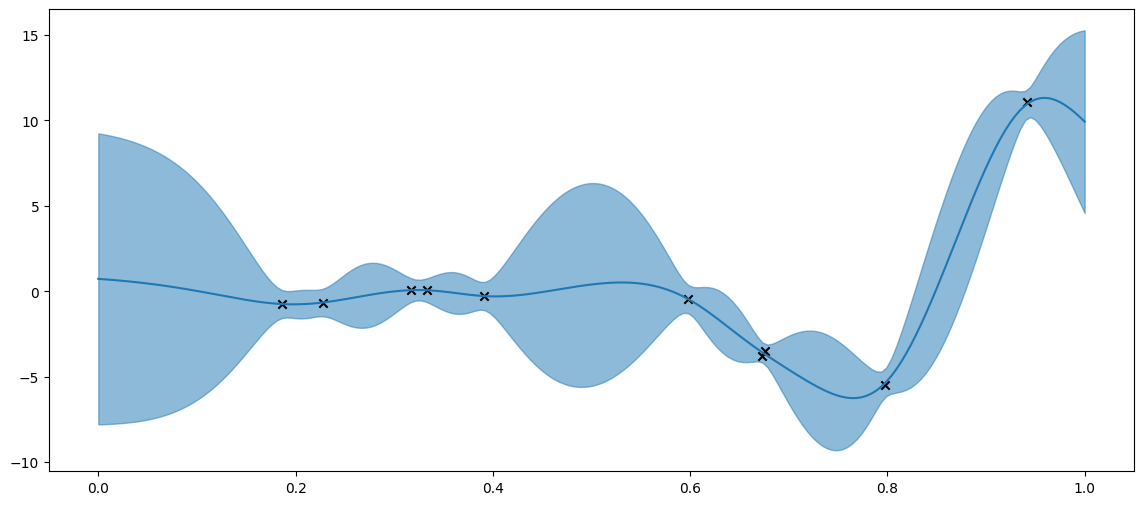

In [17]:
n = 10
X = np.random.default_rng(12345).random((n, 1))
data = f_observer(X)
search_space = search_space = trieste.space.Box([0.], [1.])
gpflow_m = trieste.models.gpflow.build_gpr(data, search_space)
m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)

optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(gpflow_m.training_loss, gpflow_m.trainable_variables)

plt.figure(figsize=(14, 6))
Xplot = np.linspace(search_space.lower, search_space.upper, 200)
Ymean, Yvar = gpflow_m.predict_f(Xplot)
line, = plt.plot(Xplot, Ymean)
plt.fill_between(Xplot[:,0],
                     Ymean[:,0] - 1.96*np.sqrt(Yvar[:,0]),
                     Ymean[:,0] + 1.96*np.sqrt(Yvar[:,0]),
                     color=line.get_color(),
                     alpha=0.5)
plt.scatter(data.query_points, data.observations, marker="x", color="black")


Now, let's have a look to see what do we need to create an acquisition, for instance the Expected improvement and the Lower Confidence Bound.

In [18]:
trieste.acquisition.function.ExpectedImprovement?

Init signature:
trieste.acquisition.function.ExpectedImprovement(
    search_space: 'Optional[SearchSpace]' = None,
)
Docstring:     
Builder for the expected improvement function where the "best" value is taken to be the minimum
of the posterior mean at observed points.

In the presence of constraints in the search_space the "best" value is computed only at the
feasible query points. If there are no feasible points, the "best" value is instead taken to be
the maximum of the posterior mean at all observed points.
Init docstring:
:param search_space: The global search space over which the optimisation is defined. This is
    only used to determine explicit constraints.
File:           ~/Projects/airc/.venv/lib/python3.11/site-packages/trieste/acquisition/function/function.py
Type:           ABCMeta
Subclasses:     

In [19]:
trieste.acquisition.function.AugmentedExpectedImprovement?

Init signature: trieste.acquisition.function.AugmentedExpectedImprovement()
Docstring:     
Builder for the augmented expected improvement function for optimization single-objective
optimization problems with high levels of observation noise.
File:           ~/Projects/airc/.venv/lib/python3.11/site-packages/trieste/acquisition/function/function.py
Type:           ABCMeta
Subclasses:     

In [20]:
trieste.acquisition.function.NegativeLowerConfidenceBound?

Init signature:
trieste.acquisition.function.NegativeLowerConfidenceBound(
    beta: 'float' = 1.96,
)
Docstring:     
Builder for the negative of the lower confidence bound. The lower confidence bound is typically
minimised, so the negative is suitable for maximisation.
Init docstring:
:param beta: Weighting given to the variance contribution to the lower confidence bound.
    Must not be negative.
File:           ~/Projects/airc/.venv/lib/python3.11/site-packages/trieste/acquisition/function/function.py
Type:           ABCMeta
Subclasses:     NegativePredictiveMean

Now we create three objects, one for each acquisition.

In [21]:
acq_EI = trieste.acquisition.function.ExpectedImprovement().prepare_acquisition_function(m, data)
acq_AEI = trieste.acquisition.function.AugmentedExpectedImprovement().prepare_acquisition_function(m, data)
acq_LCB = trieste.acquisition.function.NegativeLowerConfidenceBound(1.96).prepare_acquisition_function(m, data)

The objects acq_EI, acq_AEI, acq_LCB contain the acquisition functions and their gradients. By running the following piece of code you can visualize the three acquisitions.

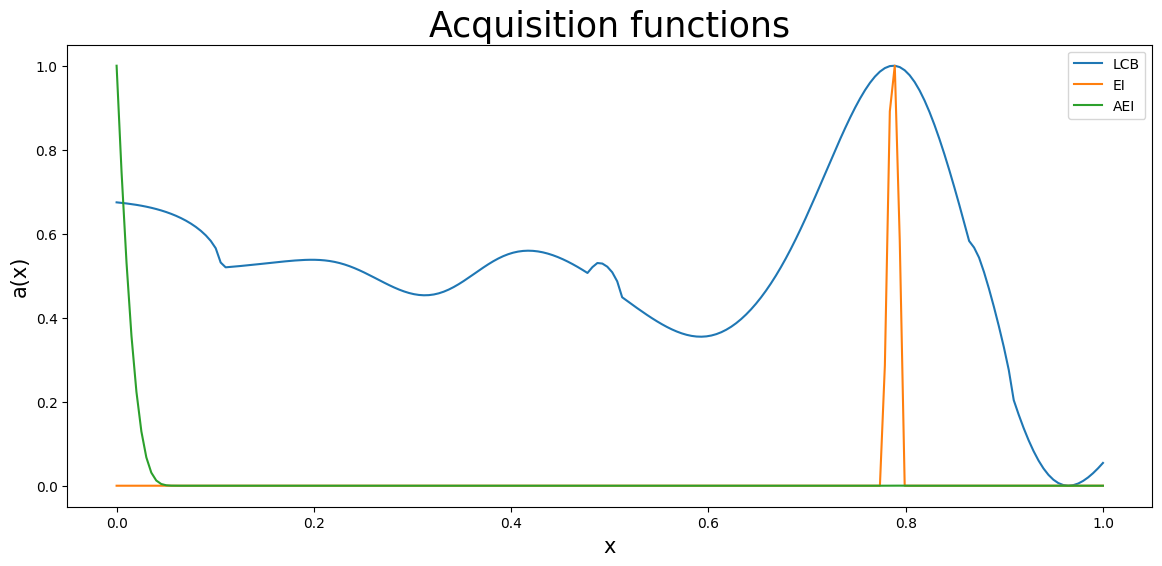

In [22]:
# Plot the three acquisition functions. Re-scale to get them on the same scale:
X_grid = np.linspace(0,1,200)[:, None]

def Y_scaled(acq):
    Y = acq(X_grid[:,None,:])
    Y_min = tf.reduce_min(Y)
    Y_max = tf.reduce_max(Y)
    Y = (Y - Y_min) / (Y_max - Y_min)
    return Y

plt.figure(figsize=(14, 6))
plt.title('Acquisition functions',size=25)
plt.plot(X_grid, Y_scaled(acq_LCB),label='LCB')
plt.plot(X_grid, Y_scaled(acq_EI),label='EI')
plt.plot(X_grid, Y_scaled(acq_AEI),label='AEI')
plt.xlabel('x',size=15)
plt.ylabel('a(x)',size=15)
plt.legend()

### Exercise 2

(a) According to the previous plot, what areas in the domain are worth exoloring and why? How can we interpret the previous plot in terms of the exploration/exploitation trade off of each one of the three acquisitions?

1. Exploitation vs. Exploration:
   - Exploitation: Focuses on areas predicted to yield high rewards, e.g., around $x = 0.8$, suggesting promising solutions.
   - Exploration: Targets areas with high uncertainty, e.g., $x < 0.1$, to gather more information.
2. Acquisition Functions:
   - Expected Improvement (EI): Prioritizes exploitation, with non-zero values at $x = 0.8$, indicating a focus on known promising regions.
   - Augmented Expected Improvement (AEI): Emphasizes exploration, as shown by a peak at $x = 0$, favoring highly uncertain areas.
   - Lower Confidence Bound (LCB): Balances exploration and exploitation by considering both predicted means and variances, offering a middle ground.

(b) Now make a plot comparing the shape of the LCB acquisition (of GP-UCB in the literature) with values different values of parameters. Use the values $[0,0.1,0.25,0.5,1,2,5]$. How does the decision about where to collect the sample change when we increase the value of the parameter?

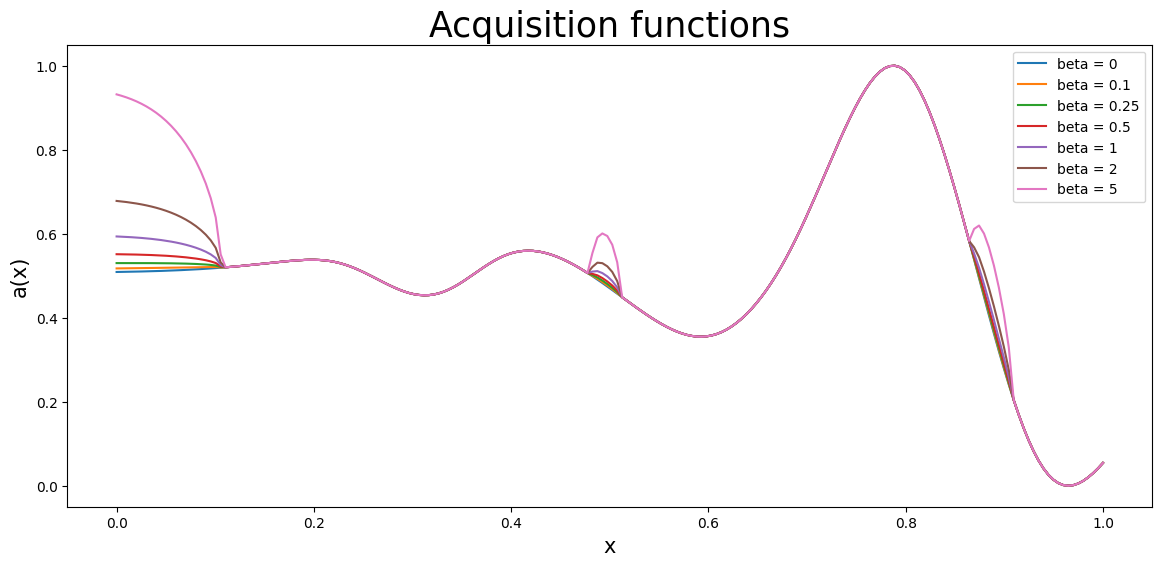

In [23]:
plt.figure(figsize=(14, 6))
plt.title('LCB with different Beta',size=25)
for beta in [0, 0.1, 0.25, 0.5, 1, 2, 5]:
    acq_LCB_beta = trieste.acquisition.function.NegativeLowerConfidenceBound(beta=beta).prepare_acquisition_function(m, data)
    plt.plot(X_grid, Y_scaled(acq_LCB_beta),label=f'beta = {beta}')
    
plt.xlabel('x',size=15)
plt.ylabel('a(x)',size=15)
plt.legend()

The plot shows higher beta increases the LCB at the domain with high uncertainty, which encourages exploration over exploitation.

### Exercise 3

Consider the sixhumpcamel function defined as
$$f(x_1,x_2) = \left(4-2.1x_1^2 + \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-2,2]\times [-1,1]$. This function has two global minima, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$.

In [24]:
def sixhumpcamel_true(x):
    x1 = x[:,0:1]
    x2 = x[:,1:2]
    term1 = (4-2.1*x1**2+(x1**4)/3) * x1**2
    term2 = x1*x2
    term3 = (-4+4*x2**2) * x2**2
    return term1 + term2 + term3

def sixhumpcamel_sim(x):
    y = sixhumpcamel_true(x)
    noise = tf.random.normal(y.shape, 0.0, 0.1, dtype=y.dtype)
    return y + noise

search_space = trieste.space.Box([-2., -1.], [2., 1.])

s_observer = trieste.objectives.utils.mk_observer(sixhumpcamel_sim)

(a) For each of the three acquisition functions 'EI', 'AEI' and 'LCB' (with parameter equal to 2), create Trieste `AcquisitionRule` 

In [39]:

acq_rule_EI = trieste.acquisition.rule.EfficientGlobalOptimization(
    trieste.acquisition.function.ExpectedImprovement()
)
acq_rule_AEI = trieste.acquisition.rule.EfficientGlobalOptimization(
    trieste.acquisition.function.AugmentedExpectedImprovement()
)
acq_rule_LCB = trieste.acquisition.rule.EfficientGlobalOptimization(
    trieste.acquisition.function.NegativeLowerConfidenceBound(beta = 2.0)
)

(b) In the three cases run the optimization for 30 iterations, using the same initial data.

In [41]:
initial_query_points = search_space.sample_sobol(3)
initial_data = s_observer(initial_query_points)

def run_bo(initial_data, search_space, observer,acq_rule):
    gpflow_m = trieste.models.gpflow.build_gpr(initial_data, search_space)
    gpflow_m.likelihood.variance.assign(1e-4)
    gpflow.set_trainable(gpflow_m.likelihood.variance, False)
    m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)
    bo = trieste.bayesian_optimizer.BayesianOptimizer(
        observer,
        search_space,
    )
    return bo.optimize(30, initial_data, m, acq_rule)

result_EI = run_bo(initial_data, search_space, s_observer, acq_rule_EI)
result_AEI = run_bo(initial_data, search_space, s_observer, acq_rule_AEI)
result_LCB = run_bo(initial_data, search_space, s_observer, acq_rule_LCB)


Optimization completed without errors
Optimization completed without errors
Optimization completed without errors


(c) Now make a plot comparing the three methods. The x axis should contain the number of iterations and y axis the best found value (Hint: see the `plot_convergence` function). Which acquisition is has the best performance in this example?

Text(0.5, 0, 'Iteration')

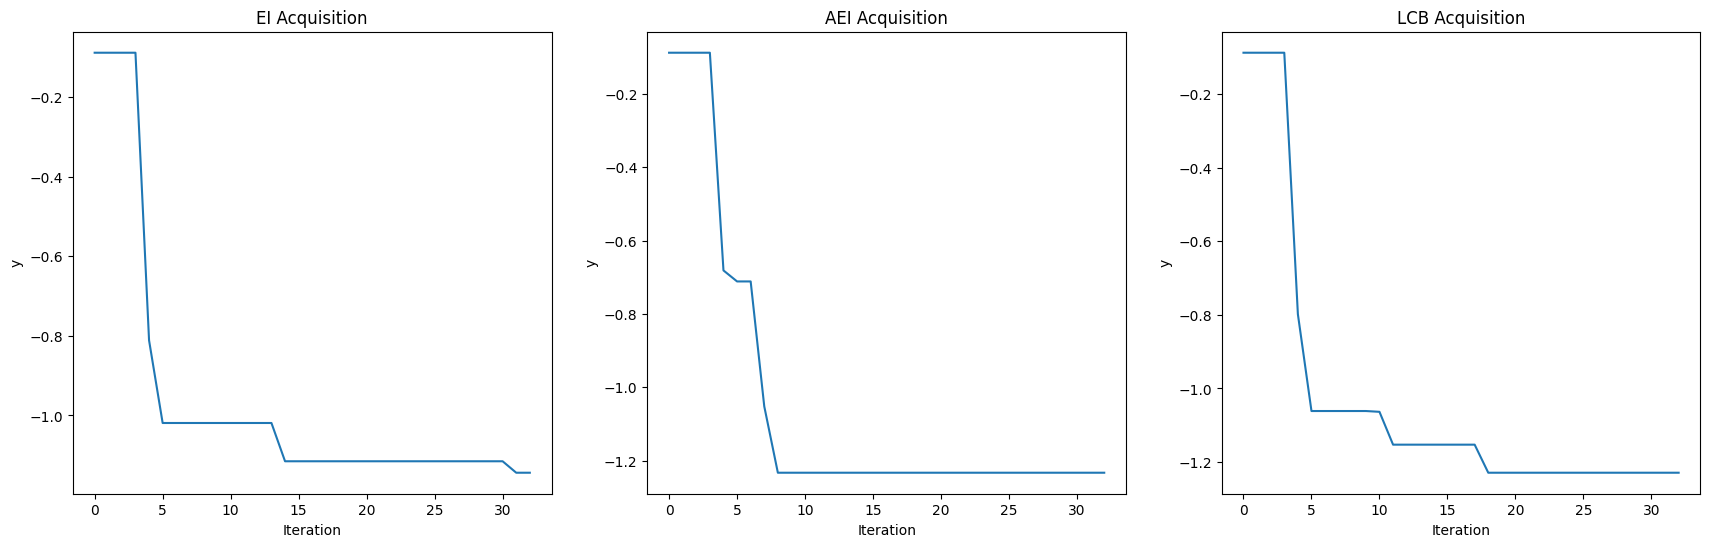

In [42]:
plt.figure(figsize=(21, 6))

plt.subplot(131)
data = result_EI.try_get_final_dataset()
best_y = tf.scan(tf.minimum, data.observations)
plt.plot(range(len(best_y)), best_y)
plt.title("EI Acquisition")
plt.ylabel("y")
plt.xlabel("Iteration")

plt.subplot(132)
data = result_AEI.try_get_final_dataset()
best_y = tf.scan(tf.minimum, data.observations)
plt.plot(range(len(best_y)), best_y)
plt.title("AEI Acquisition")
plt.ylabel("y")
plt.xlabel("Iteration")

plt.subplot(133)
data = result_LCB.try_get_final_dataset()
best_y = tf.scan(tf.minimum, data.observations)
plt.plot(range(len(best_y)), best_y)
plt.title("LCB Acquisition")
plt.ylabel("y")
plt.xlabel("Iteration")

(d) Using the below function, compare the models and the acquisition functions in the three cases (after the 30 iterations). What do you observe? 

In [50]:
def plot_bo_2d(search_space, acq, result, f_true):
    plt.figure(figsize=(12, 4))

    data = result.try_get_final_dataset()
    ss = search_space
    
    [Xi, Xj] = np.meshgrid(
        np.linspace(ss.lower[0], ss.upper[0], 100),
        np.linspace(ss.lower[1], ss.upper[1], 100),
    )
    X = np.vstack((Xi.ravel(), Xj.ravel())).T
    
    plt.subplot(131)
    plt.title("True function")
    
    Ytrue = f_true(X)
    plt.pcolormesh(Xi, Xj, tf.reshape(Ytrue, Xi.shape))
    plt.scatter(data.query_points[:, 0], data.query_points[:, 1], marker="x", color="black")
    
    plt.subplot(132)
    plt.title("Model mean")
    Ymean, Yvar = result.try_get_final_model().model.predict_y(X)
    plt.pcolormesh(Xi, Xj, tf.reshape(Ymean, Xi.shape))
    plt.scatter(data.query_points[:, 0], data.query_points[:, 1], marker="x", color="black")
    
    plt.subplot(133)
    plt.title("Acquisition function")
    Yacq = acq._acquisition_function(X[:, None, :])
    plt.pcolormesh(Xi, Xj, tf.reshape(Yacq, Xi.shape))
    plt.scatter(data.query_points[:, 0], data.query_points[:, 1], marker="x", color="black")

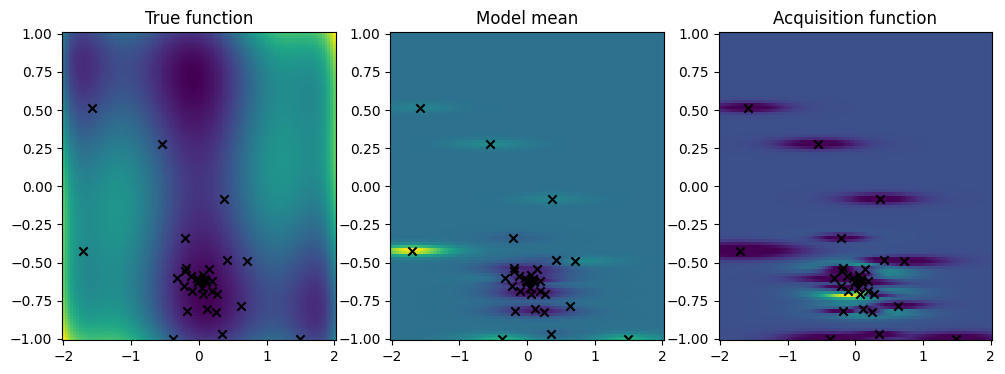

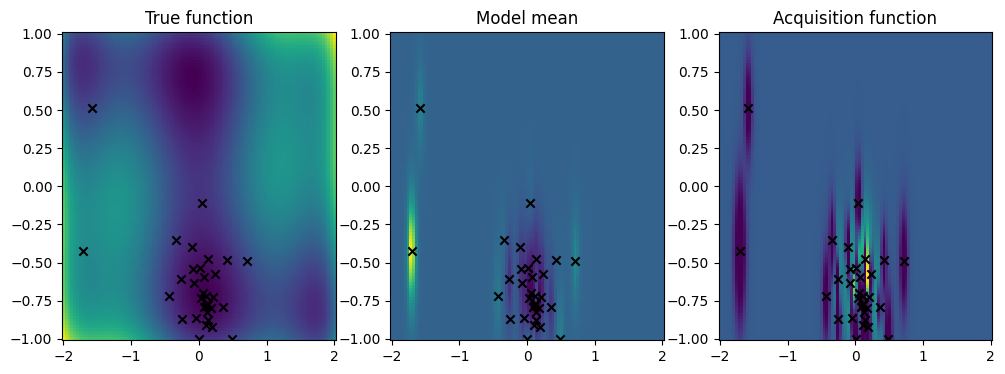

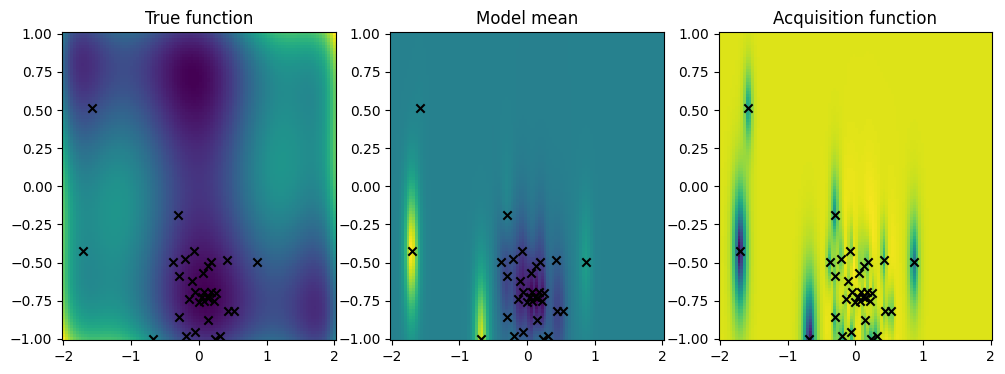

In [51]:
plot_bo_2d(search_space, acq_rule_EI, result_EI, sixhumpcamel_true)
plot_bo_2d(search_space, acq_rule_AEI, result_AEI, sixhumpcamel_true)
plot_bo_2d(search_space, acq_rule_LCB, result_LCB, sixhumpcamel_true)


---
### Credit

This notebook was written by Javier Gonzalez and edited by Liyuan Xu.